In [ ]:
#| default_exp jacobians

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import torch


class JacobianDRR(torch.nn.Module):
    """Computes the Jacobian of a DRR wrt pose parameters."""

    def __init__(self, drr, rotation, translation, parameterization, convention=None):
        super().__init__()
        self.drr = drr
        self.rotation = torch.nn.Parameter(rotation.clone())
        self.translation = torch.nn.Parameter(translation.clone())
        self.parameterization = parameterization
        self.convention = convention

    def forward(self):
        I = self.cast(self.rotation, self.translation)
        J = torch.autograd.functional.jacobian(
            self.cast,
            (self.rotation, self.translation),
            vectorize=True,
            strategy="forward-mode",
        )
        J = torch.concat([self.permute(j) for j in J], dim=0)
        return I, J

    def cast(self, rotation, translation):
        return self.drr(rotation, translation, self.parameterization, self.convention)

    def permute(self, x):
        return x.permute(-1, 0, 2, 3, 1, 4)[..., 0, 0]

In [ ]:
#| export
def gradient_matching(J0, J1):
    J0 /= J0.norm(dim=[-1, -2], keepdim=True)
    J1 /= J1.norm(dim=[-1, -2], keepdim=True)
    return (J0 - J1).norm()

In [ ]:
#| export
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def plot_img_jacobian(I, J, **kwargs):
    def fmt(x, pos):
        a, b = f"{x:.0e}".split("e")
        a = float(a)
        b = int(b)
        if a == 0:
            return "0"
        elif b == 0:
            if a < 0:
                return "-1"
            else:
                return "1"
        elif a < 0:
            return rf"$-10^{{{b}}}$"
        else:
            return rf"$10^{{{b}}}$"

    plt.figure(figsize=(10, 4), dpi=300, constrained_layout=True)
    plt.subplot(2, 4, 2)
    plt.title("J(yaw)")
    plt.imshow(J[0].squeeze().cpu().detach(), **kwargs)
    plt.colorbar(format=FuncFormatter(fmt))
    plt.axis("off")
    plt.subplot(2, 4, 3)
    plt.title("J(pitch)")
    plt.imshow(J[1].squeeze().cpu().detach(), **kwargs)
    plt.colorbar(format=FuncFormatter(fmt))
    plt.axis("off")
    plt.subplot(2, 4, 4)
    plt.title("J(roll)")
    plt.imshow(J[2].squeeze().cpu().detach(), **kwargs)
    plt.colorbar(format=FuncFormatter(fmt))
    plt.axis("off")
    plt.subplot(2, 4, 6)
    plt.title("J(x)")
    plt.imshow(J[3].squeeze().cpu().detach(), **kwargs)
    plt.colorbar(format=FuncFormatter(fmt))
    plt.axis("off")
    plt.subplot(2, 4, 7)
    plt.title("J(y)")
    plt.imshow(J[4].squeeze().cpu().detach(), **kwargs)
    plt.colorbar(format=FuncFormatter(fmt))
    plt.axis("off")
    plt.subplot(2, 4, 8)
    plt.title("J(z)")
    plt.imshow(J[5].squeeze().cpu().detach(), **kwargs)
    plt.colorbar(format=FuncFormatter(fmt))
    plt.axis("off")
    plt.subplot(2, 4, 1)
    plt.title("img")
    plt.imshow(I.cpu().detach().squeeze(), cmap="gray")
    plt.axis("off")
    plt.colorbar()
    plt.show()

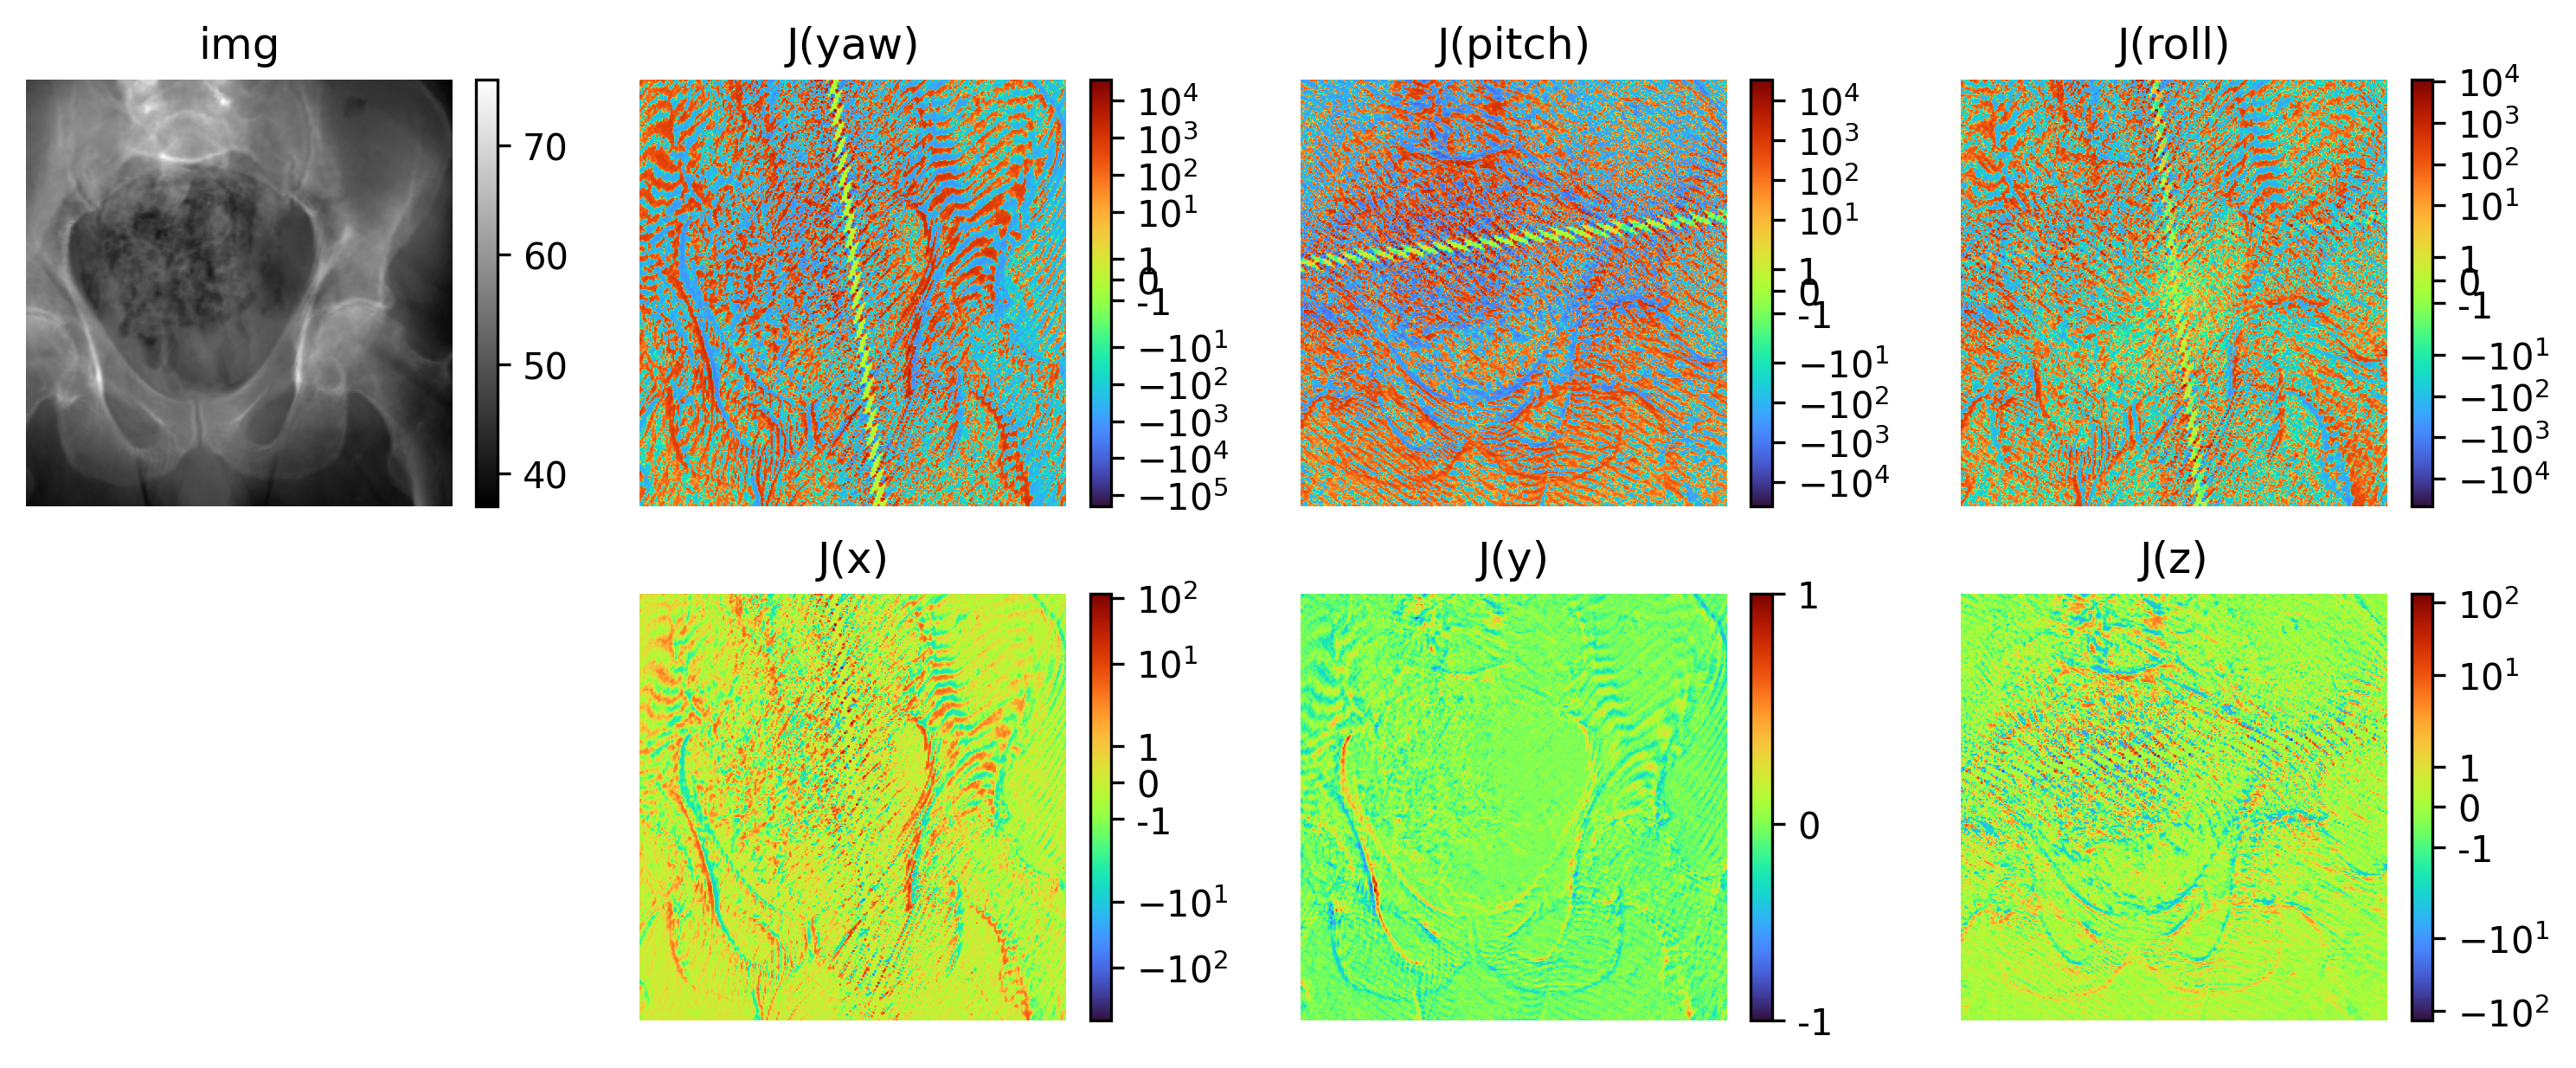

In [ ]:
#| eval: false
from diffdrr.drr import DRR
from diffdrr.utils import convert

from diffpose.deepfluoro import DeepFluoroDataset

device = torch.device("cuda")

specimen = DeepFluoroDataset(id_number=1)
height = 256
subsample = (1536 - 100) / height
delx = 0.194 * subsample

drr = DRR(
    specimen.volume,
    specimen.spacing,
    sdr=specimen.focal_len / 2,
    height=height,
    delx=delx,
    x0=specimen.x0,
    y0=specimen.y0,
    reverse_x_axis=True,
).to(device)

_, pose = specimen[52]
R = convert(pose.get_rotation(), "matrix", "euler_angles", output_convention="ZYX")
R = R.to(device)
t = pose.get_translation().to(device)

jacdrr = JacobianDRR(drr, R, t, "euler_angles", "ZYX")
I0, J0 = jacdrr()

kwargs = dict(cmap="turbo", norm="symlog")
plot_img_jacobian(I0, J0, **kwargs)

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()